 ## Import

In [2]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import warnings

from tqdm import tqdm
from time import sleep
from keras import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from skimage import io
from matplotlib import pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings('ignore')

## Function

In [3]:
def dic_tree(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = '__'
        subindent = ' ' * 2 *(level+1)
        print('{}{}/ ({})'.format((subindent+"L"+indent), os.path.basename(root), len(os.listdir(root))))

def dataset_review(dataset_type):
    dataset_path = os.path.join(os.getcwd(), dataset_type)
    folders = {}

    for folder in os.listdir(dataset_path):
        folders[folder] = len(os.listdir(os.path.join(dataset_path, folder)))

    return folders

def dataset_info(dataset_type):
    
    datasetDict = dataset_review(dataset_type)
    temp = 0

    for key in datasetDict:
        temp += datasetDict[key]

    print(f"There are {len(datasetDict)} classes with {temp} images in total",end="\n\n")

    for key, value in datasetDict.items():
        print(f"class {key} have {value} images")

def create_dir(path, folders, folder_name):

    rooth_path = os.path.join(os.getcwd(), path)

    if os.path.isdir(os.path.join(rooth_path, folder_name)):
        print(f"this path {os.path.join(rooth_path, folder_name)} already made")
    else:
        os.makedirs(os.path.join(rooth_path, folder_name))

        for folder in folders.keys():
            os.makedirs(os.path.join(rooth_path, f"{folder_name}/{folder}"))

def dataset_split(dataset_type, train_ratio, val_ratio, test_ratio, output_path):
    if os.path.isdir(os.path.join(os.getcwd(), output_path)) == False:
        os.makedirs(os.path.join(os.getcwd(), output_path))

    dlabel = dataset_review(dataset_type)
    dataset_path = os.path.join(os.getcwd(), dataset_type)

    part = "training"
    for i in range(3):
        create_dir(f"{output_path}/", dlabel, part)
        sleep(0.5)

        if part == "training":
            part = "validation"
        else:
            part = "test"

    clear_output(wait=True)
    part = "training"
    for i in range(3):
        for folder in tqdm(os.listdir(dataset_path), desc = f"| > Spliting {part} data"):
            x = 1
            
            img_path = os.path.join(dataset_path, f"{folder}/")
            ilen = len(os.listdir(img_path))

            length = (ilen * train_ratio) //100
            limit = (ilen * (val_ratio + train_ratio)) //100
            limit2 = ((ilen * (val_ratio + train_ratio + test_ratio)) //100)

            if i == 0:
                for img in os.listdir(img_path):
                    imgat = os.path.join(img_path, img)

                    if x <= length:
                        if os.path.isfile(os.path.join(os.path.join(os.getcwd(), f"{output_path}/{part}/{folder}/"), img)) == False:
                            read_image = io.imread(imgat)
                            io.imsave(f"{output_path}/{part}/{folder}/{img}", read_image)
                        else:
                            print(f"| {folder} as {part} has already been splitted! Delete /split folder to re-split!", flush=True)
                            sleep(2)
                            clear_output(wait=True)
                            break
                        sleep(0.05)
                    else:
                        break
                    x+=1

            elif i == 1:
                for img in os.listdir(img_path):
                    imgat = os.path.join(img_path, img)
                    
                    if x > length and x <= limit:
                        if os.path.isfile(os.path.join(os.path.join(os.getcwd(), f"{output_path}/{part}/{folder}/"), img)) == False:
                            read_image = io.imread(imgat)
                            io.imsave(f"{output_path}/{part}/{folder}/{img}", read_image)
                        else:
                            print(f"| {folder} as {part} has already been splitted! Delete /split folder to re-split!", flush=True)
                            sleep(2)
                            clear_output(wait=True)
                            break
                        sleep(0.05)
                    elif x > limit:
                        break
                    x+=1
                        
            else:
                for img in os.listdir(img_path):
                    imgat = os.path.join(img_path, img)
                    
                    if x > limit and x <= limit2:
                        if os.path.isfile(os.path.join(os.path.join(os.getcwd(), f"{output_path}/{part}/{folder}/"), img)) == False:
                            read_image = io.imread(imgat)
                            io.imsave(f"{output_path}/{part}/{folder}/{img}", read_image)
                        else:
                            print(f"| {folder} as {part} already has been splitted! Delete /split folder to re-split!", flush=True)
                            sleep(2)
                            clear_output(wait=True)
                            break
                        sleep(0.05)
                    elif x > limit2:
                        break
                    x+=1

        clear_output(wait=True)
        if i == 0:
            part = "validation"
        elif i == 1:
            part = "test"
        else:
            break
            
    print("| Splitting Completed!", flush=True)

>- ## Data Collecting
>> ### Dataset Source
>> Link : [Bottles Synthetic Images](https://www.kaggle.com/datasets/vencerlanz09/bottle-synthetic-images-dataset)
<br>
>> ### Dataset Info

In [4]:
dataset_info("bottle/raw/")

There are 5 classes with 25000 images in total

class Beer Bottles have 5000 images
class Plastic Bottles have 5000 images
class Soda Bottle have 5000 images
class Water Bottle have 5000 images
class Wine Bottle have 5000 images


>- ## Data Preprocessing
>> ### Data Split

In [5]:
#Split data di folder
data_raw = dataset_split(
    "bottle/raw/", 
    (80 * 20 / 100), 
    (18 * 20 / 100), 
    (2 * 20 / 100),  
    "bottle/split/"
)

| Splitting Completed!


>> ### Data Load

In [6]:
class_names = ['Beer Bottles','Plastic Bottles','Soda Bottle','Water Bottle','Wine Bottle']
p_train = "bottle/split/training/"
p_val = "bottle/split/validation/"
p_test = "bottle/split/test/"

In [14]:
img_datagenT = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.25,
    zoom_range = 0.1,
    brightness_range = (0.2, 0.4),
    horizontal_flip = True,
    fill_mode='nearest'
)

img_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [15]:
train = img_datagenT.flow_from_directory(
    p_train,
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 64,
    shuffle = True,
    class_mode = 'categorical'
)

val = img_datagen.flow_from_directory(
    p_val,
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 64,
    shuffle = True,
    class_mode = 'categorical'
)

test = img_datagen.flow_from_directory(
    p_test,
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 64,
    shuffle = True,
    class_mode = 'categorical'
)

Found 4000 images belonging to 5 classes.
Found 900 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


>- ## Data Analysis and Visualization
>> ### Raw Dataset

In [16]:
print("Data raw pada folder : ")
dic_tree(os.path.join(os.getcwd(), "bottle/raw"))

Data raw pada folder : 
  L__raw/ (5)
    L__Beer Bottles/ (5000)
    L__Plastic Bottles/ (5000)
    L__Soda Bottle/ (5000)
    L__Water Bottle/ (5000)
    L__Wine Bottle/ (5000)


In [17]:
#check raw
print("raw images :")
plt.figure(figsize=(16,9))
for i in range(15):
    plt.subplot(3, 5,i+1)
    if i > 9:
        io.imshow(f"bottle/raw/Beer Bottles/000000{i}.jpg")
    else:
        io.imshow(f"bottle/raw/Beer Bottles/0000000{i}.jpg")
    plt.axis('off')
plt.show()

raw images :


>> ### Splitted Dataset

In [10]:
print("Data setelah Split pada folder : ")
dic_tree(os.path.join(os.getcwd(), "bottle/split"))

Data setelah Split pada folder : 
  L__split/ (3)
    L__test/ (5)
      L__Beer Bottles/ (20)
      L__Plastic Bottles/ (20)
      L__Soda Bottle/ (20)
      L__Water Bottle/ (20)
      L__Wine Bottle/ (20)
    L__training/ (5)
      L__Beer Bottles/ (800)
      L__Plastic Bottles/ (800)
      L__Soda Bottle/ (800)
      L__Water Bottle/ (800)
      L__Wine Bottle/ (800)
    L__validation/ (5)
      L__Beer Bottles/ (180)
      L__Plastic Bottles/ (180)
      L__Soda Bottle/ (180)
      L__Water Bottle/ (180)
      L__Wine Bottle/ (180)


>> ### Preprocessed Dataset

Data Train :


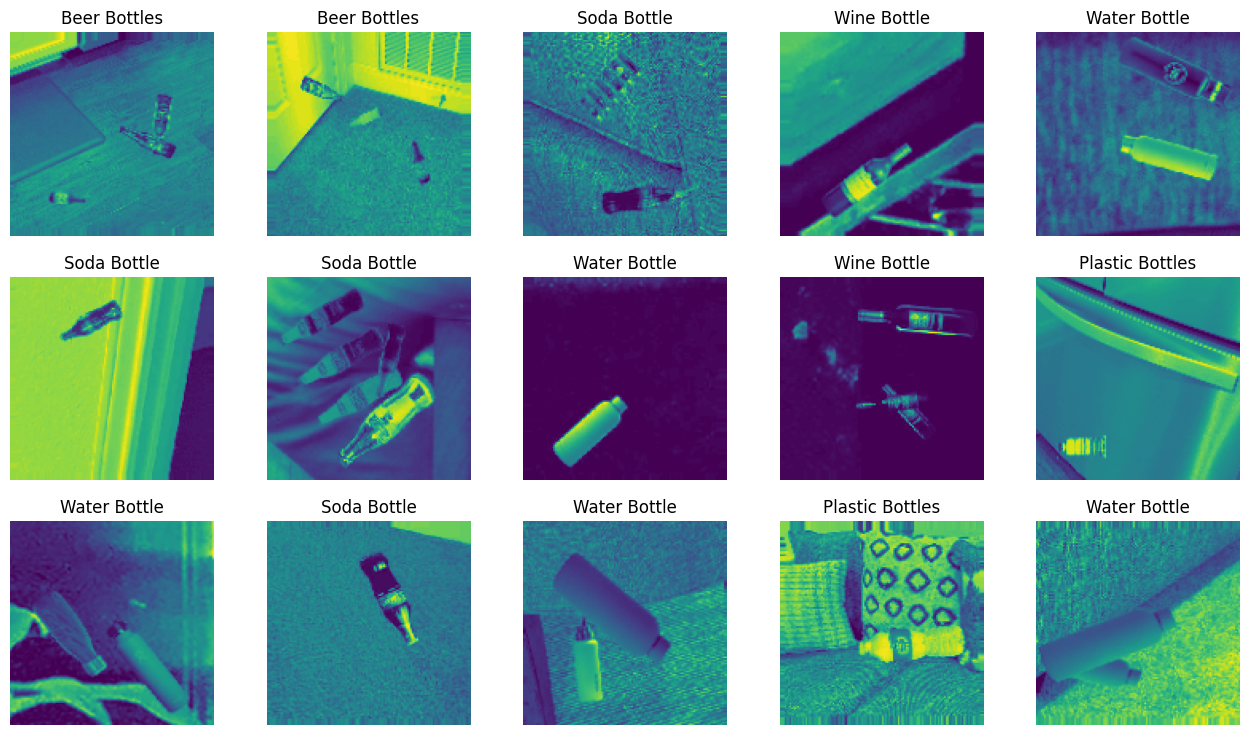

In [18]:
#check data train
print("Data Train :")
plt.figure(figsize=(16,9))
x = 1
for i in range(15):
    img, label = train.next()
    plt.subplot(3, 5, x)
    plt.title(class_names[np.argmax(label[0])])
    plt.axis('off')
    plt.imshow(img[0])
    x+=1

Data val :


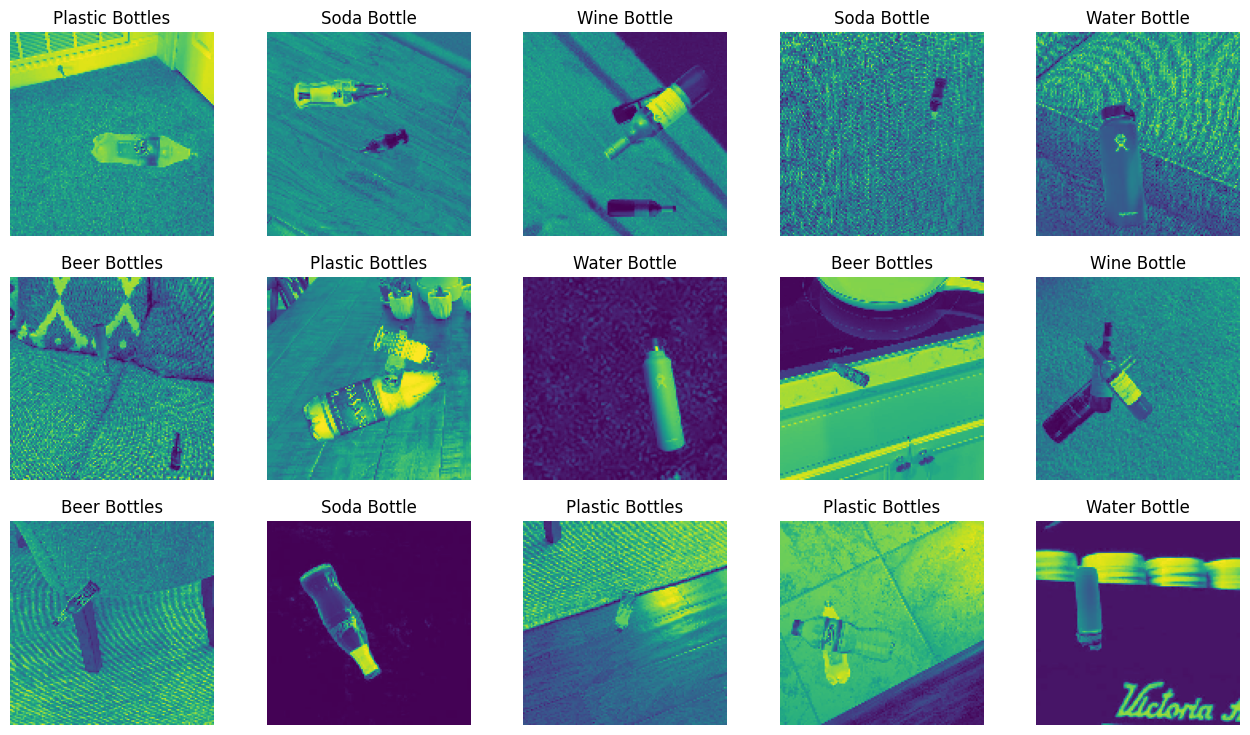

In [19]:
#check data val
print("Data val :")
plt.figure(figsize=(16,9))
x = 1
for i in range(15):
    img, label = val.next()
    plt.subplot(3, 5, x)
    plt.title(class_names[np.argmax(label[0])])
    plt.axis('off')
    plt.imshow(img[0])
    x+=1

In [13]:
#check data test
print("Data test :")
plt.figure(figsize=(16,9))
x = 1
for i in range(15):
    img, label = test.next()
    plt.subplot(3, 5, x)
    plt.title(class_names[np.argmax(label[0])])
    plt.axis('off')
    plt.imshow(img[0])
    x+=1

Data test :
